In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from joblib import dump

from src.config import DADOS_LIMPOS, MODELO_FINAL
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

import warnings

# Ignora todos os warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [4]:
coluna_target = ["median_house_value"]
coluna_one_hot_encoder = ["ocean_proximity"]
coluna_ordinal_encoder = ["median_income_cat"]

In [5]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)
colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [6]:
pipeline_robust = Pipeline(
    steps = [
        ("robust_scaler", RobustScaler()),
        ("poly", PolynomialFeatures(degree= 1, include_bias = False))
    ]
)

preprocessamento = ColumnTransformer(
    transformers=
        [
            ("one_hot_encoder",OneHotEncoder(drop = "first"), coluna_one_hot_encoder),
            ("ordinal_encoder", OrdinalEncoder(categories= "auto"), coluna_ordinal_encoder),
            ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler)
        ],
)

In [7]:
X = df.drop(columns= coluna_target)
y = df[coluna_target]

In [8]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [9]:
y

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700
...,...
17559,78100
17560,77100
17561,92300
17562,84700


In [10]:
param_grid  = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1,2,3],
    "regressor__reg__alpha": [1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0]
}

In [11]:
grid_search = grid_search_cv_regressor(
    regressor= Ridge(),
    preprocessor= preprocessamento,
    target_transformer= QuantileTransformer(output_distribution= "normal"),
    param_grid= param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [12]:
grid_search.fit(X,y)


Fitting 5 folds for each of 33 candidates, totalling 165 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [13]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 20.0}

In [14]:
grid_search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['ocean_proximity']),
                                                                                      ('ordinal_encoder',
                                                                                       OrdinalEncoder(),
                                                                                       ['median_income_cat']),
                                                                                      ('robust_scaler_poly',
                                                                                       Pipeline(steps=[('robust_scaler',
                                                                                                        RobustScaler()),
                                                                                                       ('poly',
                                                                                                        PolynomialFeatures(degree=3,
                                                                                                                           include_bias=False))]),
                                                                                       Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                     ('reg',
                                                      Ridge(alpha=20.0))]),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [15]:
#RSME
grid_search.best_score_

np.float64(-50454.803932096554)

In [16]:
target_transformer = PowerTransformer()

regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy= "mean"),
        "target_transformer": None,
    },
    "LinearRegressor": {
        "preprocessor": preprocessamento,
        "regressor":LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegressor_target": {
        "preprocessor": preprocessamento,
        "regressor":LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    
    "Ridge_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor":grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    }
}

In [17]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler_poly__longitude,-0.884932
robust_scaler_poly__latitude,-0.781194
one_hot_encoder__ocean_proximity_INLAND,-0.495789
robust_scaler_poly__population_per_household,-0.334535
robust_scaler_poly__latitude^2,-0.298768
...,...
robust_scaler_poly__housing_median_age longitude^2,0.193079
robust_scaler_poly__latitude median_income population_per_household,0.212627
robust_scaler_poly__housing_median_age median_income,0.248097
robust_scaler_poly__bedrooms_per_room,0.318015


In [18]:
coefs[coefs["coeficiente"].between(-0.2,0.2)]

,coeficiente
one_hot_encoder__ocean_proximity_NEAR BAY,-0.198110
robust_scaler_poly__longitude^3,-0.196414
robust_scaler_poly__longitude^2 rooms_per_household,-0.177447
robust_scaler_poly__latitude^2 median_income,-0.172254
robust_scaler_poly__latitude^2 population,-0.170171
...,...
robust_scaler_poly__latitude^3,0.172178
robust_scaler_poly__bedrooms_per_room median_income,0.176410
robust_scaler_poly__longitude median_income population_per_household,0.181233
robust_scaler_poly__latitude^2 longitude,0.184694


In [19]:
coefs[coefs["coeficiente"].between(-0.2,0.2) & coefs["coeficiente"] != 0]

,coeficiente
one_hot_encoder__ocean_proximity_NEAR BAY,-0.198110
robust_scaler_poly__longitude^3,-0.196414
robust_scaler_poly__longitude^2 rooms_per_household,-0.177447
robust_scaler_poly__latitude^2 median_income,-0.172254
robust_scaler_poly__latitude^2 population,-0.170171
...,...
robust_scaler_poly__latitude^3,0.172178
robust_scaler_poly__bedrooms_per_room median_income,0.176410
robust_scaler_poly__longitude median_income population_per_household,0.181233
robust_scaler_poly__latitude^2 longitude,0.184694


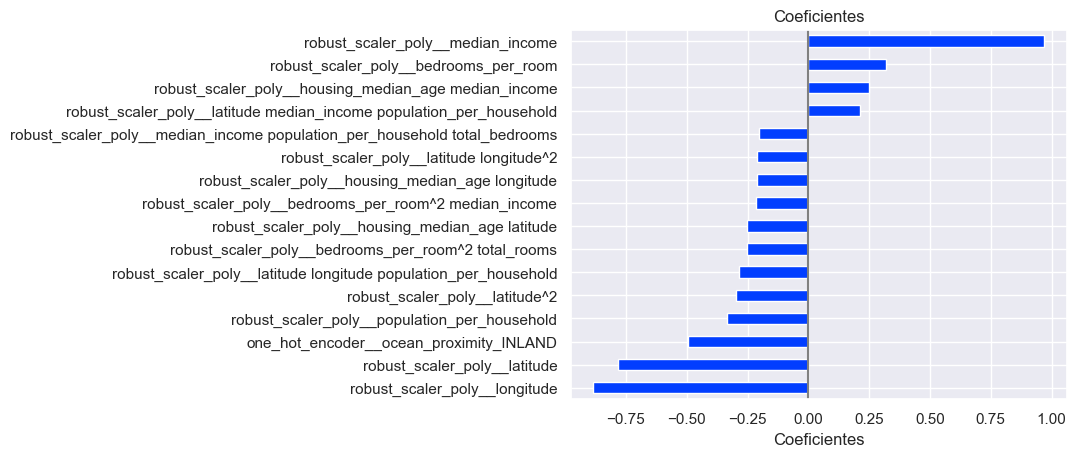

In [20]:
plot_coeficientes(coefs[~coefs["coeficiente"].between(-0.2,0.2) & coefs["coeficiente"] != 0])

In [21]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

In [22]:
df_resultados = organiza_resultados(resultados)
df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.005984,0.010972,-0.000081,-77516.042766,-96239.705692,0.016956
1,DummyRegressor,0.00524,0.010966,-0.000146,-75787.787194,-95217.629397,0.016206
2,DummyRegressor,0.005982,0.009376,-0.001737,-76753.598961,-96253.253947,0.015357
3,DummyRegressor,0.004986,0.005756,-0.000101,-76837.804811,-95983.885799,0.010741
4,DummyRegressor,0.0,0.025594,-0.000114,-76617.245449,-96182.764729,0.025594
5,LinearRegressor,0.122655,0.031636,0.682162,-39855.690996,-54254.958188,0.154291
6,LinearRegressor,0.15475,0.022302,0.66999,-40272.565467,-54695.230283,0.177052
7,LinearRegressor,0.125922,0.018796,0.649247,-42178.05929,-56955.988706,0.144718
8,LinearRegressor,0.119072,0.035252,0.669873,-40806.492497,-55146.318803,0.154324
9,LinearRegressor,0.150959,0.014928,0.669023,-40788.496497,-55331.35106,0.165887


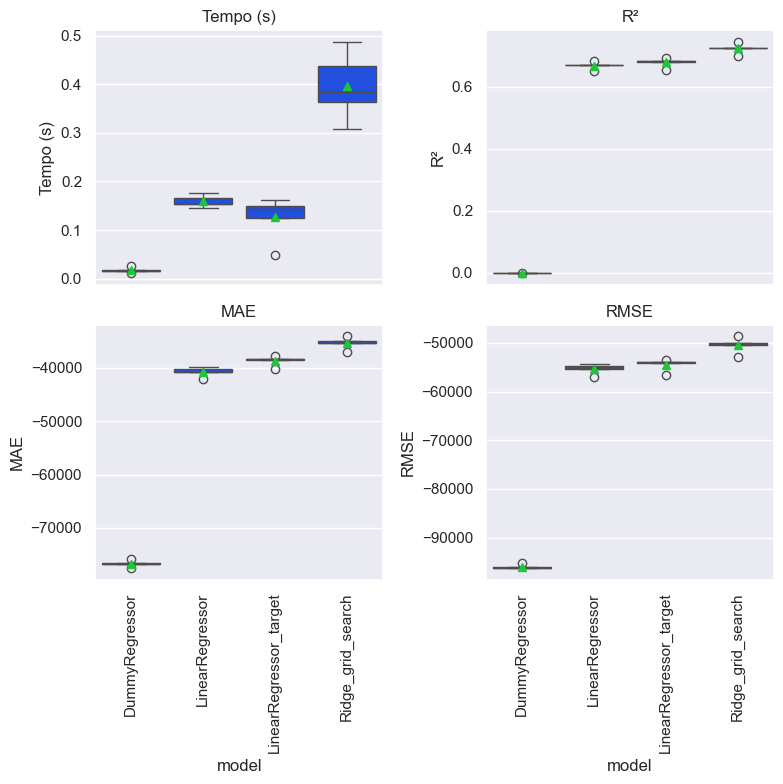

In [23]:
plot_comparar_metricas_modelos(df_resultados)

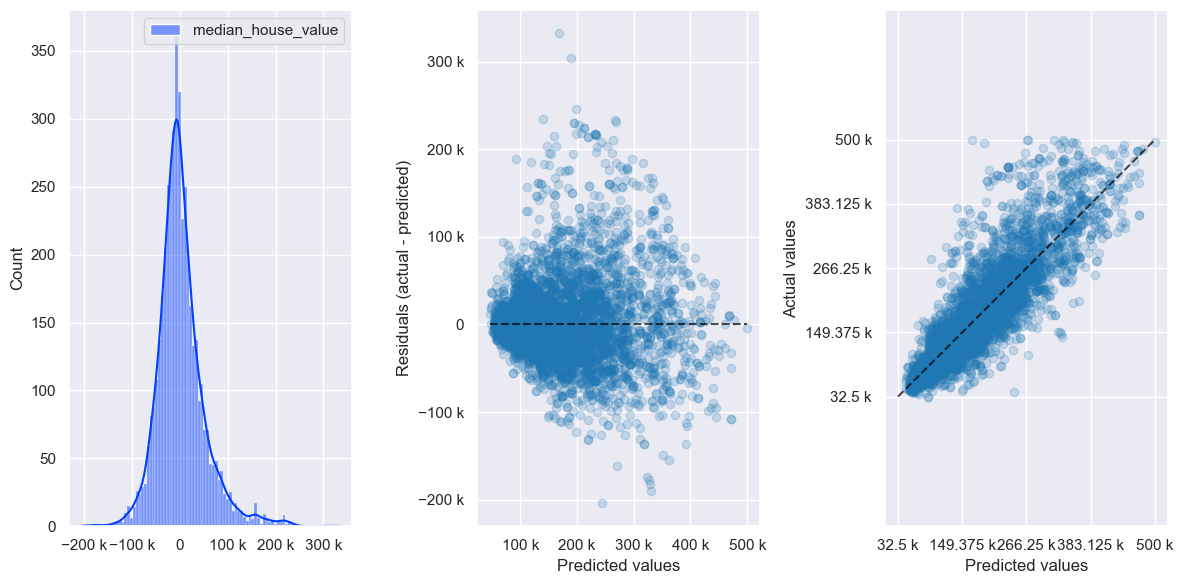

In [24]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra= 0.25, eng_formatter= True)

In [25]:
dump(grid_search.best_estimator_, MODELO_FINAL)

['C:\\Users\\useca\\Desktop\\Julio Python\\JV Regressão com Scikit-Learn - Algoritmos Lineares\\Projeto de Regressão\\modelo_projeto_data_science\\modelos\\ridge_polyfeat_target_quantile.joblib']

In [26]:
#!pip install streamlit